In [8]:
from symbol import parameters

from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
from dotenv import load_dotenv
import warnings
import tiktoken
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec
from openai import OpenAI
import time
from src.embeddings import *
from src.data_processing import *
import tqdm
import itertools
import tqdm


warnings.filterwarnings("ignore")
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.getenv("PINECONE_API_KEY")


## Prepare Data

### Load Document

In [3]:
folder_path = "../Data/Raw"
metadata: List[Dict[str, Any]] = []
chunk_id = 0
chunk_token_size = []

# Iterate over each file in the folder with a progress bar.
for filename in tqdm.tqdm(os.listdir(folder_path), desc="Processing files"):
    file_title = os.path.basename(filename)
    # Process only files that end with '.txt'
    if filename.lower().endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        try:
            # Open and read the file content.
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            continue

        text = text.split("Subpart")
        for t in text:
          subpart_title = t.split("\n")[0]
          for s in t.split("\nSec."):
              section_title = s.split("\n")[0]
              text_token_size = count_tokens_gpt4(t)
              chunk_token_size.append(text_token_size)
              chunk_id += 1
              metadata.append({
                  "title": file_title,
                  "subpart_title": subpart_title,
                  "section_title": section_title,
                  "content": s,
                  "token_count": text_token_size
              })
print(len(metadata))

Processing files: 100%|██████████| 9/9 [01:40<00:00, 11.17s/it]

11670


## Original Dataset


255819


<Axes: ylabel='Count'>

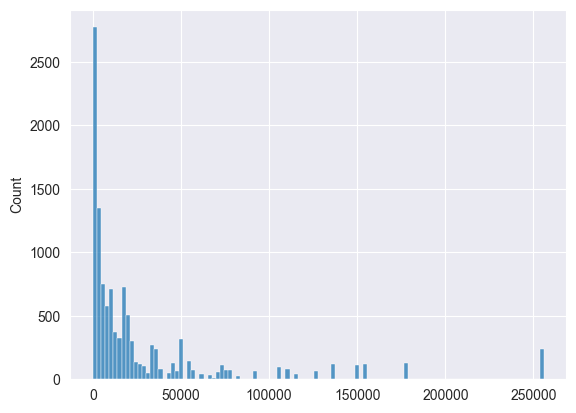

In [4]:
import seaborn as sns
print(max(chunk_token_size))
sns.histplot(chunk_token_size)

### Adjusted Dataset


In [5]:
new_metadata : List[Dict[str, Any]] = []
id = 0

for i in tqdm.tqdm(range(len(metadata))):
    if metadata[i]["token_count"] < 3200:
        new_metadata.append({
                    "id": id,
                    "title": metadata[i]["title"],
                    "subpart_title": metadata[i]["subpart_title"],
                    "section_title": metadata[i]["section_title"],
                    "content": metadata[i]["content"].replace("\n", ""),
                    "token_count": count_tokens_gpt4(metadata[i]["content"])
                })
        # Update Counter
        id += 1
    else:
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(model_name="gpt-4",
                                                                             chunk_size=3200,
                                                                             chunk_overlap=0,)
        texts = text_splitter.create_documents([metadata[i]["content"]])
        for t in texts:
            new_metadata.append({
                    "id": id,
                    "title": metadata[i]["title"],
                    "subpart_title": metadata[i]["subpart_title"],
                    "section_title": metadata[i]["section_title"],
                    "content": t.page_content.replace("\n", ""),
                    "token_count": count_tokens_gpt4(t.page_content)
                })
            # Update Counter
            id += 1

print(len(new_metadata))


100%|██████████| 11670/11670 [00:07<00:00, 1470.18it/s]

12415


<Axes: ylabel='Count'>

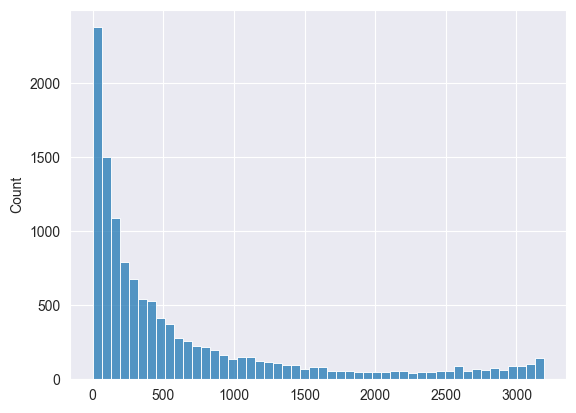

In [6]:
count = []
for d in new_metadata:
    count.append(d["token_count"])
sns.histplot(count)


## Prepare Upsert Data

### Pinecone

In [9]:
vectors = get_dataset_embeddings_parallel(new_metadata)
len(vectors)

100%|██████████| 12415/12415 [08:33<00:00, 24.19it/s] 


12415

In [10]:
sorted_vectors = sorted(vectors, key=lambda chunk: int(chunk['id']))

In [12]:
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key=pinecone_api_key)
index_name = "legal-hierarchical-rag"
# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        name=index_name,
        dimension=3072,  # dimensionality of embed 3
        metric='cosine',
        spec=ServerlessSpec(
    cloud="aws", region="us-east-1"  # us-east-1
)
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
print(index.describe_index_stats())

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}


In [13]:
index.upsert(vectors=vectors, batch_size=25)

Upserted vectors:   0%|          | 0/12415 [00:00<?, ?it/s]

upserted_count: 12415

In [14]:
print(index.describe_index_stats())

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 13040}},
 'total_vector_count': 13040}


In [15]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
query = "What are the main business requirements for Regulation K?"
xq = client.embeddings.create(input=query, model="text-embedding-3-large").data[0].embedding
res = index.query(vector=xq, top_k=20, include_metadata=True)
res

{'matches': [{'id': '9002',
              'metadata': {'content': '211.1 Authority, purpose, and '
                                      'scope.211.2 Definitions.211.3 Foreign '
                                      'branches of U.S. banking '
                                      'organizations.211.4 Permissible '
                                      'investments and activities of foreign '
                                      'branches of           member '
                                      'banks.211.5 Edge and agreement '
                                      'corporations.211.6 Permissible '
                                      'activities of Edge and agreement '
                                      'corporations in the           United '
                                      'States.211.7 Voluntary liquidation of '
                                      'Edge and agreement corporations.211.8 '
                                      'Investments and activities abroad.211.9 '

In [16]:
for i in range(len(res.matches)):
    print(res.matches[i]["metadata"]["title"], res.matches[i]["score"])

CFR-2024-title12-vol2.txt 0.5856433
CFR-2024-title12-vol2.txt 0.5785187
CFR-2024-title12-vol2.txt 0.57570535
CFR-2024-title12-vol2.txt 0.54999644
CFR-2024-title12-vol4.txt 0.5410523
CFR-2024-title12-vol3.txt 0.5327788
CFR-2024-title12-vol2.txt 0.5313643
CFR-2024-title12-vol2.txt 0.53078514
CFR-2024-title12-vol10.txt 0.53013283
CFR-2024-title12-vol10.txt 0.5268812
CFR-2024-title12-vol3.txt 0.5266495
CFR-2024-title12-vol4.txt 0.5224615
CFR-2024-title12-vol4.txt 0.52074385
CFR-2024-title12-vol2.txt 0.51740664
CFR-2024-title12-vol2.txt 0.5156225
CFR-2024-title12-vol2.txt 0.5148581
CFR-2024-title12-vol4.txt 0.5102192
CFR-2024-title12-vol4.txt 0.5091467
CFR-2024-title12-vol2.txt 0.5032944
CFR-2024-title12-vol2.txt 0.5028161
